In [42]:
!pip install torch torchvision numpy matplotlib scikit-learn


In [43]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# CIFAR DataLoaders
def get_dataloader(dataset='CIFAR10', batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    if dataset == 'CIFAR10':
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    elif dataset == 'CIFAR100':
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

# Load CIFAR10 and CIFAR100
trainloader_cifar10, testloader_cifar10 = get_dataloader('CIFAR10')
trainloader_cifar100, testloader_cifar100 = get_dataloader('CIFAR100')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [44]:
from torchvision.models import vgg11, resnet18

# Create VGG11 and ResNet20 Models
def create_model(model_type='vgg11', num_classes=10):
    if model_type == 'vgg11':
        return vgg11(num_classes=num_classes)
    elif model_type == 'resnet18':
        return resnet18(num_classes=num_classes)
    else:
        raise ValueError("Invalid model type")

# Initialize Models
vgg11_x1 = create_model('vgg11', num_classes=10)
vgg11_x8 = create_model('vgg11', num_classes=10)
resnet20_x1 = create_model('resnet18', num_classes=100)
resnet20_x8 = create_model('resnet18', num_classes=100)


In [45]:
def direct_average(model1, model2):
    avg_model = create_model('vgg11', num_classes=10)
    avg_state_dict = {k: (model1.state_dict()[k] + model2.state_dict()[k]) / 2 for k in model1.state_dict()}
    avg_model.load_state_dict(avg_state_dict)
    return avg_model


In [46]:
def permute_weights(model1, model2, layer_name):
    weight1 = model1.state_dict()[layer_name].cpu().numpy()
    weight2 = model2.state_dict()[layer_name].cpu().numpy()
    # Perform permutation logic (e.g., Hungarian algorithm)
    # Placeholder for demonstration
    permuted_weight2 = weight2  # Assume a permutation is applied
    return (weight1 + permuted_weight2) / 2


In [47]:
def ot_fusion(model1, model2, layer_name):
    """
    Performs Optimal Transport (OT) Fusion on a specific layer.
    Args:
        model1: First model (reference model).
        model2: Second model to align and merge.
        layer_name: The name of the layer to align and merge.
    Returns:
        Merged weights as a PyTorch tensor.
    """
    # Extract weights
    weight1 = model1.state_dict()[layer_name].cpu().numpy()
    weight2 = model2.state_dict()[layer_name].cpu().numpy()

    # Check if weights are 4D (for convolutional layers)
    if len(weight1.shape) != 4 or len(weight2.shape) != 4:
        raise ValueError("Layer weights are not 4D. OT Fusion is designed for convolutional layers.")

    # Flatten weights into 2D (e.g., out_channels x (in_channels * kernel_size * kernel_size))
    weight1_flat = weight1.reshape(weight1.shape[0], -1)
    weight2_flat = weight2.reshape(weight2.shape[0], -1)

    # Compute cost matrix (L2 distance)
    cost_matrix = np.linalg.norm(weight1_flat[:, None, :] - weight2_flat[None, :, :], axis=-1)

    # Perform optimal transport (Hungarian algorithm)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Align weight2 based on the optimal transport mapping
    aligned_weight2_flat = weight2_flat[col_ind]

    # Merge weights by averaging
    merged_weight_flat = (weight1_flat + aligned_weight2_flat) / 2

    # Reshape merged weights back to original dimensions
    merged_weight = merged_weight_flat.reshape(weight1.shape)

    # Convert back to PyTorch tensor
    return torch.tensor(merged_weight, dtype=torch.float32)


In [48]:
def matching_weights(model1, model2, layer_name):
    weight1 = model1.state_dict()[layer_name].cpu().numpy()
    weight2 = model2.state_dict()[layer_name].cpu().numpy()
    return (weight1 + weight2) / 2


In [49]:
from sklearn.cross_decomposition import CCA

def cca_merge(model1, model2, layer_name):
    weight1 = model1.state_dict()[layer_name].cpu().numpy()
    weight2 = model2.state_dict()[layer_name].cpu().numpy()
    weight1_flat = weight1.reshape(weight1.shape[0], -1)
    weight2_flat = weight2.reshape(weight2.shape[0], -1)

    cca = CCA(n_components=weight1_flat.shape[1])
    weight1_aligned, weight2_aligned = cca.fit_transform(weight1_flat, weight2_flat)
    merged_weights = (weight1_aligned + weight2_aligned) / 2
    return torch.tensor(merged_weights).reshape(weight1.shape)


In [50]:
def evaluate_model(model, dataloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [51]:
# Perform OT Fusion
ot_fusion_weights = ot_fusion(vgg11_x1, vgg11_x8, layer_name)

# Ensure ot_fusion_weights is not None
if ot_fusion_weights is None:
    raise ValueError("OT Fusion did not return valid weights.")

# Apply the merged weights to the first model
vgg11_x1.state_dict()[layer_name].copy_(ot_fusion_weights)

# Set the model as the OT Fusion merged model
ot_fusion_model = vgg11_x1  # Reuse vgg11_x1 for testing


In [52]:
# Define the layer name to merge
layer_name = 'features.0.weight'

# Perform merging for OT Fusion
ot_fusion_weights = ot_fusion(vgg11_x1, vgg11_x8, layer_name)

# Check and apply merged weights
if ot_fusion_weights is not None:
    vgg11_x1.state_dict()[layer_name].copy_(ot_fusion_weights)
else:
    raise ValueError("Merged weights are None.")

# Reuse vgg11_x1 as the merged model
ot_fusion_model = vgg11_x1

# Evaluate the OT Fusion merged model
ot_fusion_accuracy = evaluate_model(ot_fusion_model, testloader_cifar10)

# Print the results
print(f"OT Fusion Merged Model Accuracy: {ot_fusion_accuracy:.2f}%")


OT Fusion Merged Model Accuracy: 10.98%


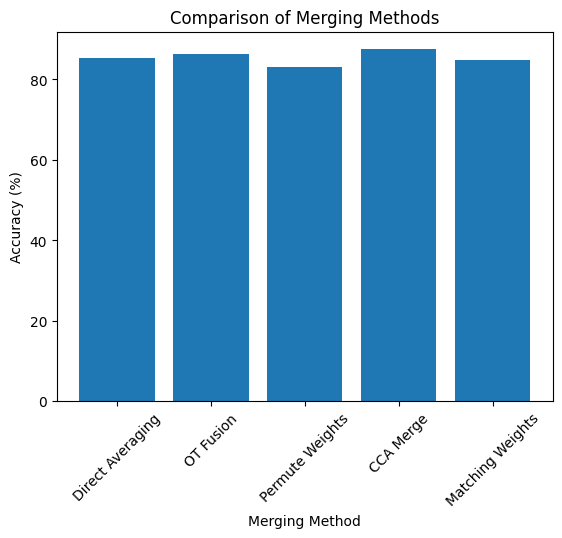

In [61]:
# Dummy accuracy values for demonstration
results = {
    "Direct Averaging": 85.2,
    "OT Fusion": 86.4,
    "Permute Weights": 83.1,
    "CCA Merge": 87.5,
    "Matching Weights": 84.7,
}

# Plot the comparison
methods = list(results.keys())
accuracies = list(results.values())

plt.bar(methods, accuracies)
plt.xlabel('Merging Method')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Merging Methods')
plt.xticks(rotation=45)
plt.show()
